**<h3>Preface</h3>**

This Notebook explores various methods to burn mapping.

**Objective**

Find binary classification of burn mapping. After a fire, a specific location (a pixel) is either burned or unburned. 


**Resources available**

4 Sentinel-2 bands:

+ B12 SWIR 2:       2190 nm

+ B11 SWIR 1:       1610 nm

+ B9  Water Vapour: 945 nm

+ B8 NIR:           842 nm

**Quality Inspection**

How good is the classification. Since we don't have too much of a ground truth. 

Quality can be checked against an official perimeter (not perfect).

For now, we can expect some False Positives, but the goal is to reduce them as much as possible.

**Benefit**

After binary burn mapping is done, a severity mapping is more meaningful.

    E.g: Burn Mapping as a mask for BARC, better than BARC itself

**Acknowledgements**

We try our best to classify using only the 4 bands available. We have not yet know "the features" that can help with mapping 100% correctly, but a useful method is the goal of our team's. 

An area can be burned today, and shows less signal some time later. So the choice of pre-fire and post-fire data to map burn needs careful considerations in order to see the "true impact".

E.g: By choosing very close dates, one can see nothing as burned or a very far away distance in dates can be misleading for several reasons (the burned area is healing and shows less signal,...)

Snow, cloud coverage can be obstructions for the mapping.

Thus, burn mapping requires some assumptions we should make, nothing is perfect, but can be a useful source of study.

<u>We can't easily use ground truth</u>, 

    for example, the colour of burn can be very different, depending on various factors like the landscape, which was burned, ...

In [1]:
from plot_tools import (
    plot
)

import matplotlib.pyplot as plt

In [2]:
from raster import Raster

In [19]:
import numpy as np

In [20]:
a = np.array([
    [1,2,3],
    [4,5,6]
])

a.flatten()

array([1, 2, 3, 4, 5, 6])

**File names**

In [4]:
pre_fire_file = "S2C_MSIL2A_20250609T192931_N0511_R142_T09UYU_20250610T002612_cloudfree.bin_MRAP_C11659.bin_crop.bin"
post_fire_file = "S2A_MSIL2A_20251009T193831_N0511_R142_T09UYU_20251009T234613_cloudfree.bin_MRAP_C11659.bin_crop.bin"
polygon_file = 'rasterized_0000.bin'

**Read all bands**

We will read 3 things, all in 4 bands

1. Pre Fire

2. Post Fire

3. Change Detection (Later)

In [5]:
pre_fire_raster  = Raster(file_name=pre_fire_file)
post_fire_raster = Raster(file_name=post_fire_file)

In [6]:
pre_fire_raster.band_info_list

['MSIL2A 20m: B12 2190nm',
 'MSIL2A 20m: B11 1610nm',
 'MSIL2A 60m: B9 945nm',
 'MSIL2A 10m: B8 842nm']

In [7]:
pre_fire_dat = pre_fire_raster.read_bands()
post_fire_dat= post_fire_raster.read_bands()

Read all 4 band(s)
Read all 4 band(s)


**Raterize the perimeter**

By rasterizing the perimeter, we can colour map all the data within it.

In [8]:
perimeter = Raster(polygon_file)

In [9]:
#Since perimeter has just 1 band, out band list is [1]
perimeter_dat = perimeter.read_bands([1], info=True)

---------------------
Your selected bands:
gray_scale, unknown band
---------------------
Data Dimension: (1496, 1354, 1)


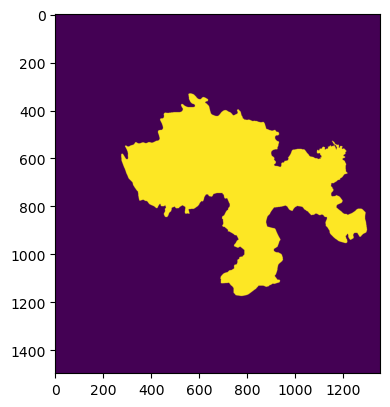

In [10]:
plot(perimeter_dat, figsize=(4,6))

**Perimeter masking**

Let's have 2 separate matrix, one contains data inside and one outside of the perimeter

In [11]:
from polygon import split_in_out

In [13]:
_, _ , post_inside, post_outside = split_in_out(
    raster_filename=post_fire_file,
    polygon_filename=polygon_file
)

Read all 4 band(s)


In [14]:
out_in_ratio = len(post_outside) / len(post_inside)
out_in_ratio

4.59227632512541

In [17]:
np.isnan(post_outside).sum()

np.int64(0)

In [15]:
len(post_inside)

362211

**Sampling**

We will be using tnse.

Caveat: tsne could take a while to reduce, our data is simply too large. We can sample a portion of it, just to have a quick look.

We want to sample say, 10% of the data **without nan**. A module to resample should be written as well.

In [ ]:
from sampling import row_sampling

In [ ]:
#Sample size determination
in_sample_size = 1_000
out_sample_size = int(in_sample_size * out_in_ratio)

#Sample now
post_inside_samples  = row_sampling(post_inside, size=in_sample_size)
post_outside_samples = row_sampling(post_outside, size=out_sample_size)

In [ ]:
#Stack the 2 data for tsne

post_X = np.vstack([
    post_inside_samples,
    post_outside_samples
])

**TSNE**

We want to see, for all the data "trapped" inside the perimeter, how would they behave in TSNE dimensionality reduction.

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [ ]:
post_X_s = StandardScaler().fit_transform(post_X)

In [ ]:
#We will use this param setting for all data
tsne_params = {
    'n_components': 2,
    'perplexity': 30,
    'learning_rate': "auto",
    'init': "pca",
    'random_state': 42
}

In [ ]:
tsne = TSNE(**tsne_params)

Y = tsne.fit_transform(post_X_s) #Takes Too long !!!!

**Plot TSNE**

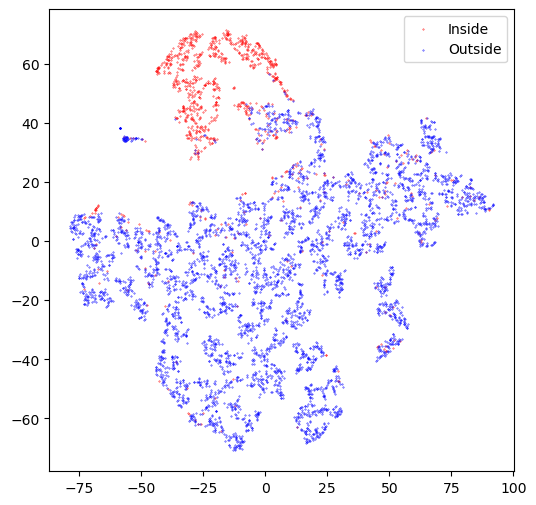

In [ ]:
plt.figure(figsize=(6, 6))

plt.scatter(Y[:in_sample_size, 0], Y[:in_sample_size, 1],
            s=0.1, c="red", label="Inside")

plt.scatter(Y[in_sample_size:, 0], Y[in_sample_size:, 1],
            s=0.1, c="blue", label="Outside")

plt.legend()
plt.show()

**PCA**

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
Y_pca = PCA(n_components=2).fit_transform(post_X_s)

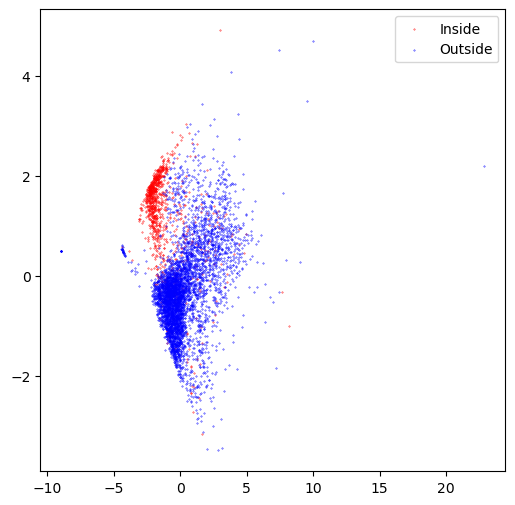

In [ ]:
plt.figure(figsize=(6, 6))

plt.scatter(Y_pca[:in_sample_size, 0], Y_pca[:in_sample_size, 1],
            s=0.1, c="red", label="Inside")

plt.scatter(Y_pca[in_sample_size:, 0], Y_pca[in_sample_size:, 1],
            s=0.1, c="blue", label="Outside")

plt.legend()
plt.show()

No idea why they look so bad. Let's try classification now.

**Classification**